In [1]:
drive_path = '/home/kameron/work/allen/data/sdk_new_100'
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
# Options are: 10, 25, 50, 100
resolution_um=100

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
manifest_file = os.path.join(drive_path, "manifest.json")

mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

# open up a pandas dataframe of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print "%d total experiments" % len(all_experiments)

# take a look at what we know about an experiment with a primary motor injection
all_experiments.loc[122642490]

2173 total experiments


gender                                                                   M
id                                                               122642490
injection-coordinates                                   [4020, 2160, 6870]
injection-structures     [{u'abbreviation': u'MOp', u'color': u'1F9D5A'...
strain                                                               B6.Cg
structure-abbrev                                                       MOp
structure-color                                                     1F9D5A
structure-id                                                           985
structure-name                                          Primary motor area
transgenic-line                                             Syt6-Cre_KI148
Name: 122642490, dtype: object

In [2]:
import allensdk

In [3]:
help(mcc.get_experiments)

Help on method get_experiments in module allensdk.core.mouse_connectivity_cache:

get_experiments(self, dataframe=False, file_name=None, cre=None, injection_structure_ids=None) method of allensdk.core.mouse_connectivity_cache.MouseConnectivityCache instance
    Read a list of experiments that match certain criteria.  If caching is enabled,
    this will save the whole (unfiltered) list of experiments to a file.
    
    Parameters
    ----------
    
    dataframe: boolean
        Return the list of experiments as a Pandas DataFrame.  If False,
        return a list of dictionaries.  Default False.
    
    file_name: string
        File name to save/read the structures table.  If file_name is None,
        the file_name will be pulled out of the manifest.  If caching
        is disabled, no file will be saved. Default is None.
    
    cre: boolean or list
        If True, return only cre-positive experiments.  If False, return only
        cre-negative experiments.  If None, return a

In [4]:
#stree = mcc.get_structure_tree()

In [5]:
# grab the Ontology instance
ontology = mcc.get_ontology()

# get some info on the isocortex
isocortex = ontology['Isocortex']
isocortex_mask, _ = mcc.get_structure_mask(isocortex['id'])

/home/kameron/local/anaconda2/lib/python2.7/site-packages/allensdk/core/mouse_connectivity_cache.py:314: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  structures = pd.DataFrame.from_csv(file_name)


In [6]:
import numpy as np
np.sum(isocortex_mask)

121743

In [7]:
help(np.repeat)

Help on function repeat in module numpy.core.fromnumeric:

repeat(a, repeats, axis=None)
    Repeat elements of an array.
    
    Parameters
    ----------
    a : array_like
        Input array.
    repeats : int or array of ints
        The number of repetitions for each element.  `repeats` is broadcasted
        to fit the shape of the given axis.
    axis : int, optional
        The axis along which to repeat values.  By default, use the
        flattened input array, and return a flat output array.
    
    Returns
    -------
    repeated_array : ndarray
        Output array which has the same shape as `a`, except along
        the given axis.
    
    See Also
    --------
    tile : Tile an array.
    
    Examples
    --------
    >>> np.repeat(3, 4)
    array([3, 3, 3, 3])
    >>> x = np.array([[1,2],[3,4]])
    >>> np.repeat(x, 2)
    array([1, 1, 2, 2, 3, 3, 4, 4])
    >>> np.repeat(x, 3, axis=1)
    array([[1, 1, 1, 2, 2, 2],
           [3, 3, 3, 4, 4, 4]])
    >>> np.rep

In [9]:
import h5py
vi = h5py.File(r'/home/kameron/work/allen/data/ccf_2017/dorsal_flatmap_paths_10.h5', 'r')
lut = vi['view lookup'][:]
paths = vi['paths'][:]
vi.close()

In [10]:
print lut.max()
print lut.shape
print paths.max()
print paths.shape

711821
(1320, 1140)
945982017
(711822, 200)


In [10]:
experiment_id = 181599674

# projection density: number of projecting pixels / voxel volume
pd, pd_info = mcc.get_projection_density(experiment_id)

In [11]:
pd_info

{u'dimension': 3,
 u'encoding': 'gzip',
 u'endian': 'little',
 u'keyvaluepairs': {},
 u'kinds': ['domain', 'domain', 'domain'],
 u'sizes': [132, 80, 114],
 u'space': 'left-posterior-superior',
 u'space directions': [['100', '0', '0'],
  ['0', '100', '0'],
  ['0', '0', '100']],
 u'space origin': ['0', '0', '0'],
 u'type': 'float'}

In [12]:
pd.shape

(132, 80, 114)

In [13]:
from skimage.transform import rescale
test = rescale(pd, 10, order=0)
test.shape

/home/kameron/local/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1320, 800, 114)

In [14]:
from scipy.ndimage import zoom 
pdrep = zoom(pd,10,order=0)

In [16]:
import skimage
skimage.__version__

'0.13.1'

In [15]:
pdrep.shape

(1320, 800, 1140)

In [17]:
132*80*114*10**3

1203840000

In [18]:
# calculate output array
output_pd = np.zeros(lut.shape, dtype=pdrep.dtype)
 
# all pixels in surface view with a stream line
ind = np.where(lut > -1)
ind = zip(ind[0], ind[1])
 
for curr_ind in ind:
    curr_path_id = lut[curr_ind]
    curr_path = paths[curr_path_id, :]
    curr_pd_line = pdrep.flat[curr_path]
    curr_max_ind = curr_path[np.argmax(curr_pd_line)]
    output_pd[curr_ind] = pdrep.flat[curr_max_ind]

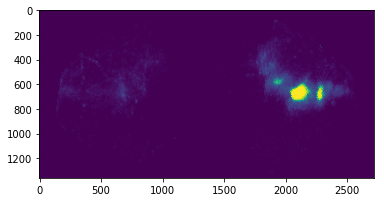

In [20]:
import matplotlib.pyplot as plt
plt.imshow(output_pd)
plt.show()

In [23]:
drive_path = '/home/kameron/work/allen/data/sdk_new_10'

# When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
# Options are: 10, 25, 50, 100
resolution_um=10

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
manifest_file = os.path.join(drive_path, "manifest.json")

mcc10 = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

In [ ]:
experiment_id = 181599674

# projection density: number of projecting pixels / voxel volume
pd, pd_info = mcc10.get_projection_density(experiment_id)

In [ ]:
pd.shape

In [ ]:
pd.dtype

In [ ]:
pd_info

In [ ]:
# calculate output array
output_pd = np.zeros(lut.shape, dtype=pd.dtype)
 
# all pixels in surface view with a stream line
ind = np.where(lut > -1)
ind = zip(ind[0], ind[1])
 
for curr_ind in ind:
    curr_path_id = lut[curr_ind]
    curr_path = paths[curr_path_id, :]
    curr_pd_line = pd.flat[curr_path]
    curr_max_ind = curr_path[np.argmax(curr_pd_line)]
    output_pd[curr_ind] = pd.flat[curr_max_ind]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(output_pd)

In [ ]:
plt.show()